# Maximum Likelihood Estimation (MLE) and Maximum a Posteriori (MAP)

In [1]:
import sys; sys.path.append("..")
import numpy as np
from utils.optimization import gd, sgd
import matplotlib.pyplot as plt
import scipy

np.random.seed(42)

## Dataset creation

In [2]:
def generalizedVander(funcs, x):
    V = np.zeros((len(x), len(funcs)))
    for j, fn in enumerate(funcs):
        V[:, j] = fn(np.array(x))
    return V

def Phi(X, K):
    return generalizedVander([ (lambda x, coef=j: x**coef) for j in range(K) ], X)


def createDataset(N, a, b, K, theta_true, variance):
    X_full = np.linspace(a, b, N)
    Y_full = Phi(X_full, K) @ theta_true + np.random.normal(0, np.sqrt(variance), N)
    return X_full, Y_full

def train_test_split(X, Y, train_size, random_seed=42):
    idxs = np.arange(0, X.shape[0])
    np.random.default_rng(random_seed).shuffle(idxs)
    X_train = X[idxs[:train_size]]
    Y_train = Y[idxs[:train_size]]
    X_test = X[idxs[train_size:]]
    Y_test = Y[idxs[train_size:]]

    return X_train, Y_train, X_test, Y_test

In [3]:
N = 1000
K = 4
a, b = -1, 1
variance = 0.1
theta_true = np.ones(K)

X_full, Y_full = createDataset(N, a, b, K, theta_true, variance)
X_train, Y_train, X_test, Y_test = train_test_split(X_full, Y_full, int(0.75*X_full.shape[0]))

print(f"Train shape: {X_train.shape} | {Y_train.shape}")
print(f"Test shape: {X_test.shape} | {Y_test.shape}")

Train shape: (750,) | (750,)
Test shape: (250,) | (250,)


## Evaluation utilities

In [4]:
def avgAbsoluteError(model, X, Y):
    return (1/Y.shape[0]) * (np.linalg.norm(model.predict(X) - Y, 2)**2)

def thetaError(model, theta_true):
    padded_theta = np.zeros(model.theta.shape)
    padded_theta[:theta_true.shape[0]] = theta_true
    return np.linalg.norm(model.theta - padded_theta, 2) / np.linalg.norm(padded_theta, 2)

In [5]:
def plotDataForVaryingK(model, X_train, Y_train, X_test, Y_test, real_K, K_variation=3, fig_size=(18, 10), plot_error=False):
    plt.figure(figsize=fig_size)
    to_test_K = [*range(max(1, real_K-K_variation), real_K)] + [real_K] + [*range(real_K+1, real_K+K_variation+1)]
    train_errors = []
    test_errors = []

    plt.plot(X_train, Y_train, ".", alpha=0.3, label="Train data")
    plt.plot(X_test, Y_test, ".", alpha=0.3, label="Test data")
    for K in to_test_K:
        model.K = K
        model.fit(X_train, Y_train, epochs=1000)
        train_errors.append( avgAbsoluteError(model, X_train, Y_train) )
        test_errors.append( avgAbsoluteError(model, X_test, Y_test) )

        print(f"K={K} | Avg absolute error: [test] {test_errors[-1]:<20} | [train] {train_errors[-1]:<20}")
        plot_X = np.linspace(a, b, 10000)
        plt.plot(plot_X, model.predict(plot_X), "-", label=f"K={K}", linewidth=2)
    plt.legend()
    plt.show()

    if plot_error:
        plt.figure(figsize=(18, 4))
        plt.title("Average absolute errors")
        plt.plot(to_test_K, train_errors, label="Train")
        plt.plot(to_test_K, test_errors, label="Test")
        plt.xlabel("K")
        plt.xticks(to_test_K)
        plt.legend()
        plt.show()

## Maximum Likelihood Estimation

In [6]:
class Regressor:
    def __init__(self, K):
        self.theta = None
        self.K = K

    def _loss(self, theta, Phi_X, Y):
        raise NotImplementedError()

    def _grad_loss(self, theta, Phi_X, Y):
        raise NotImplementedError()

    def fit(self, X, Y, batch_size=500, epochs=100, lr=1e-3):
        history_w, history_loss, history_grad, history_err = sgd(
            loss = self._loss, 
            grad_loss = self._grad_loss,
            w0 = np.zeros(self.K),
            data = (Phi(X, self.K).T, Y),
            batch_size = batch_size,
            n_epochs = epochs,
            lr = lr,
        )

        # print(f"Loss: {[round(h, 2) for h in history_loss]}")
        # print(f"Gradient norm: {[round(h, 2) for h in history_err]}")
        self.theta = history_w[-1]
        return self

    def fit_gd(self, X, Y, epochs=100, tol_loss=1e-6, tol_theta=1e-6, lr=1e-3):
        history_w, curr_k, history_loss, history_grad, history_err = gd(
            loss = self._loss, 
            grad_loss = self._grad_loss,
            w0 = np.zeros(self.K),
            data = (Phi(X, self.K).T, Y),
            k_max = epochs,
            tol_loss = tol_loss,
            tol_w = tol_theta,
            alpha = None
        )
        self.theta = history_w[-1]
        return self
        

    def predict(self, X):
        return Phi(X, self.K) @ self.theta

In [7]:
class MLERegressor(Regressor):
    def __init__(self, K):
        super().__init__(K)

    def _loss(self, theta, Phi_X, Y):
        return (1/2)*np.linalg.norm(Y - theta @ Phi_X)**2

    def _grad_loss(self, theta, Phi_X, Y):
        return -(Y.T @ Phi_X.T - theta.T @ Phi_X @ Phi_X.T)
    

    def fit_neq(self, X, Y):
        Phi_X = Phi(X, self.K)
        self.theta = scipy.linalg.cho_solve( scipy.linalg.cho_factor(Phi_X.T @ Phi_X), (Phi_X.T @ Y) )
        return self

K=1 | Avg absolute error: [test] 1.0003840110349915   | [train] 1.1197719867486513  


K=2 | Avg absolute error: [test] 0.1942315639146457   | [train] 0.21849502892659622 
K=3 | Avg absolute error: [test] 0.11070582296674955  | [train] 0.12478689112786172 
K=4 | Avg absolute error: [test] 0.08541347811824153  | [train] 0.09902954437221738 
K=5 | Avg absolute error: [test] 0.08516445271397427  | [train] 0.09846510893387912 
K=6 | Avg absolute error: [test] 0.08520470733910483  | [train] 0.09845053213626254 
K=7 | Avg absolute error: [test] 0.08502916123596185  | [train] 0.09849572145145612 


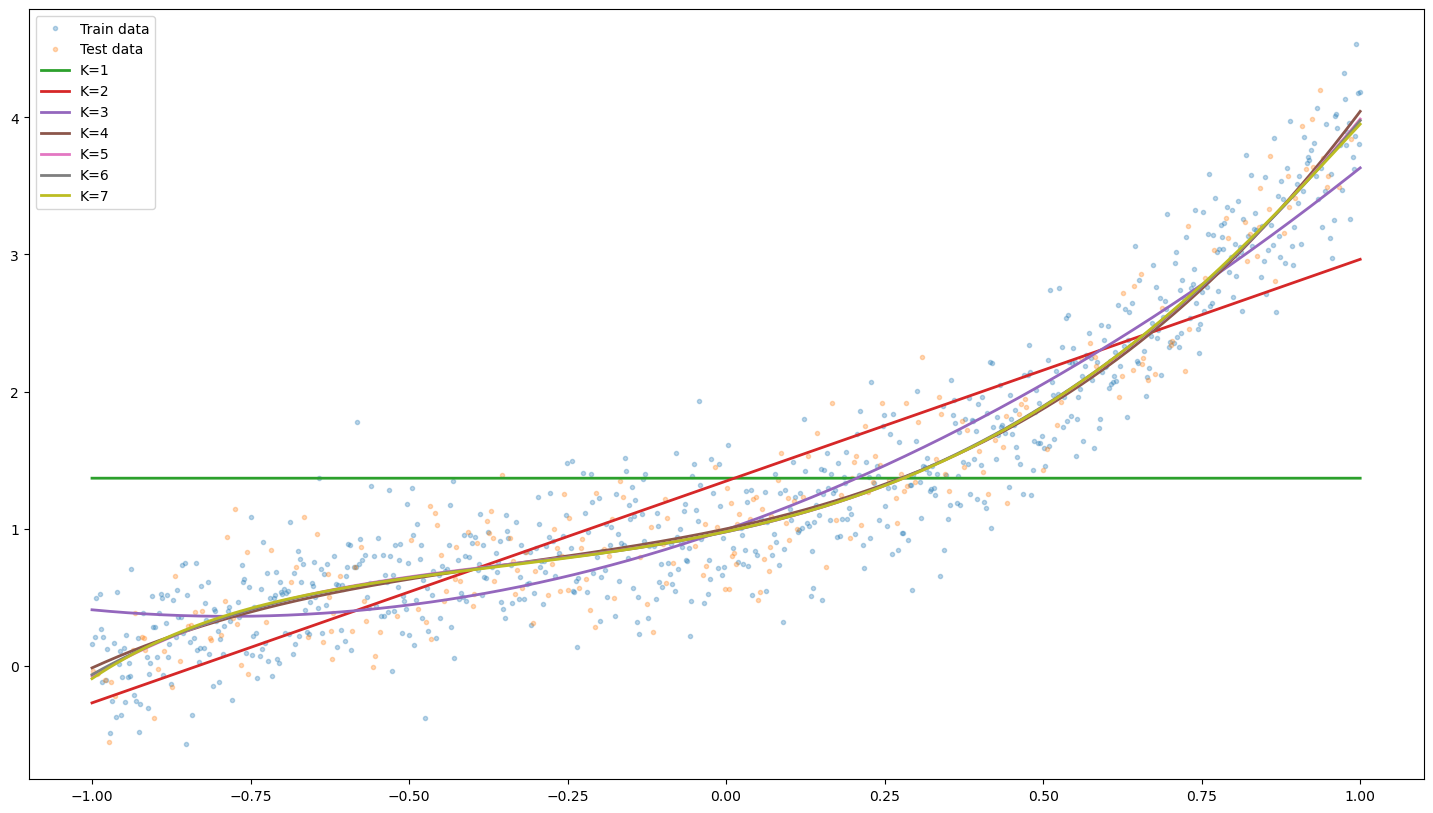

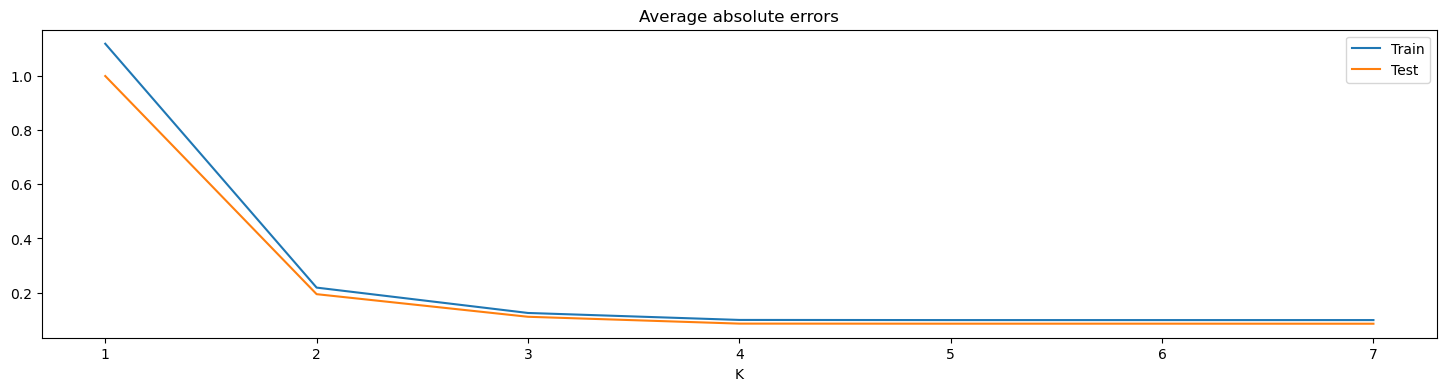

In [8]:
plotDataForVaryingK(MLERegressor(K=None), X_train, Y_train, X_test, Y_test, real_K=K, plot_error=True)

## Maximum a Posteriori

In [9]:
class MAPRegressor(Regressor):
    def __init__(self, K, lamb):
        super().__init__(K)
        self.lamb = lamb

    def _loss(self, theta, Phi_X, Y):
        return (1/2)*(np.linalg.norm(Y - theta @ Phi_X)**2) + (1/2)*(self.lamb*np.linalg.norm(theta, 2)**2)

    def _grad_loss(self, theta, Phi_X, Y):
        return -(Y.T @ Phi_X.T - theta.T @ Phi_X @ Phi_X.T) + (self.lamb*theta)
    
    def fit_neq(self, X, Y):
        Phi_X = Phi(X, self.K)
        self.theta = scipy.linalg.cho_solve( scipy.linalg.cho_factor((Phi_X.T @ Phi_X) + (self.lamb*np.identity(Phi_X.shape[1]))), (Phi_X.T @ Y) )
        return self

>>>>> lambda = 0.1 <<<<<
K=2 | Avg absolute error: [test] 0.1942124040878794   | [train] 0.2184988574778934  
K=3 | Avg absolute error: [test] 0.11071101878758893  | [train] 0.12479110447087756 
K=4 | Avg absolute error: [test] 0.08543236203144214  | [train] 0.0990326375697352  
K=5 | Avg absolute error: [test] 0.08517001680330509  | [train] 0.09850975870612896 
K=6 | Avg absolute error: [test] 0.0851585153652275   | [train] 0.09856317378265401 


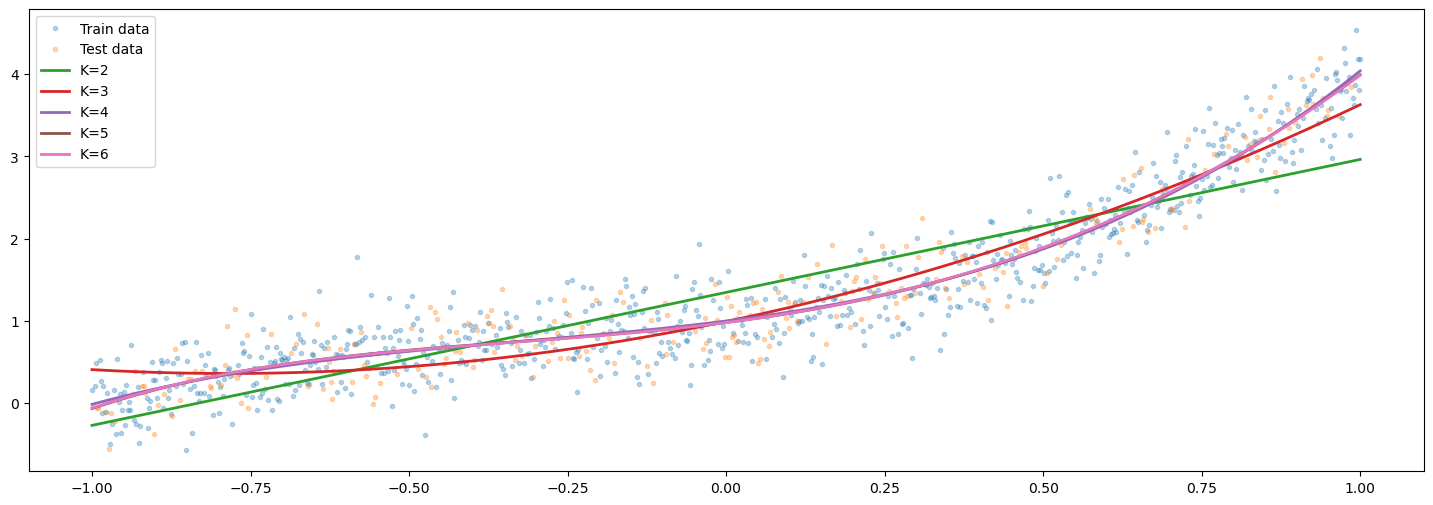

>>>>> lambda = 0.325 <<<<<
K=2 | Avg absolute error: [test] 0.19417357568778368  | [train] 0.2185124830329493  
K=3 | Avg absolute error: [test] 0.11072917105895627  | [train] 0.12480777391638147 
K=4 | Avg absolute error: [test] 0.08548177941221019  | [train] 0.09904836254696228 
K=5 | Avg absolute error: [test] 0.08525165943642593  | [train] 0.09866040642600753 
K=6 | Avg absolute error: [test] 0.0851404876383237   | [train] 0.09884466202361247 


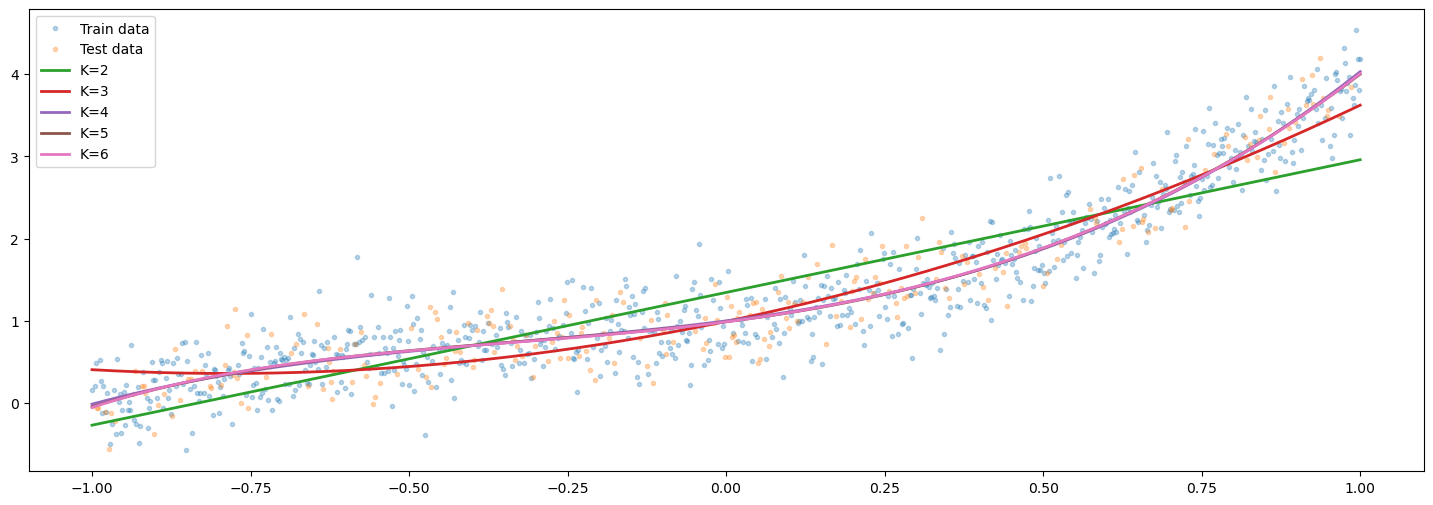

>>>>> lambda = 0.55 <<<<<
K=2 | Avg absolute error: [test] 0.194140632548529    | [train] 0.21853299711957963 
K=3 | Avg absolute error: [test] 0.11075610351993093  | [train] 0.12483422918086574 
K=4 | Avg absolute error: [test] 0.08554006681402639  | [train] 0.09907534214538181 
K=5 | Avg absolute error: [test] 0.08539160718426511  | [train] 0.09884829647437135 
K=6 | Avg absolute error: [test] 0.08519652172016562  | [train] 0.09913530431713148 


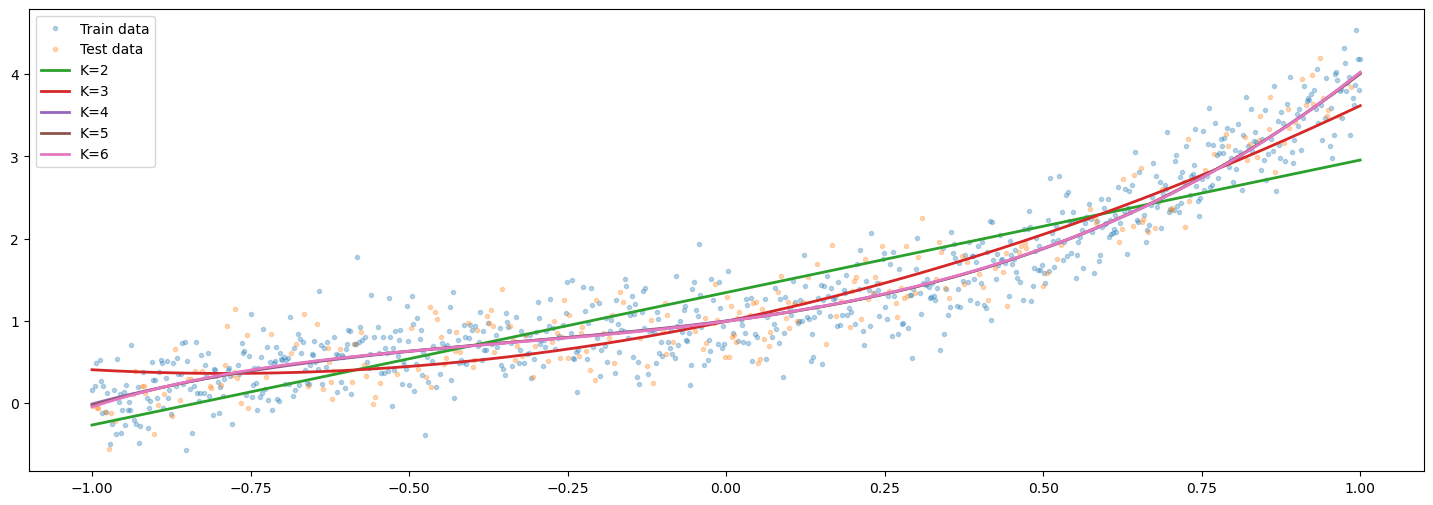

>>>>> lambda = 0.775 <<<<<
K=2 | Avg absolute error: [test] 0.194113522868663    | [train] 0.2185603386324193  
K=3 | Avg absolute error: [test] 0.11079161788818563  | [train] 0.12487026927740015 
K=4 | Avg absolute error: [test] 0.0856064645233531   | [train] 0.09911264579321576 
K=5 | Avg absolute error: [test] 0.08556172381575328  | [train] 0.09905032005442035 
K=6 | Avg absolute error: [test] 0.08529272585242204  | [train] 0.09941621561449152 


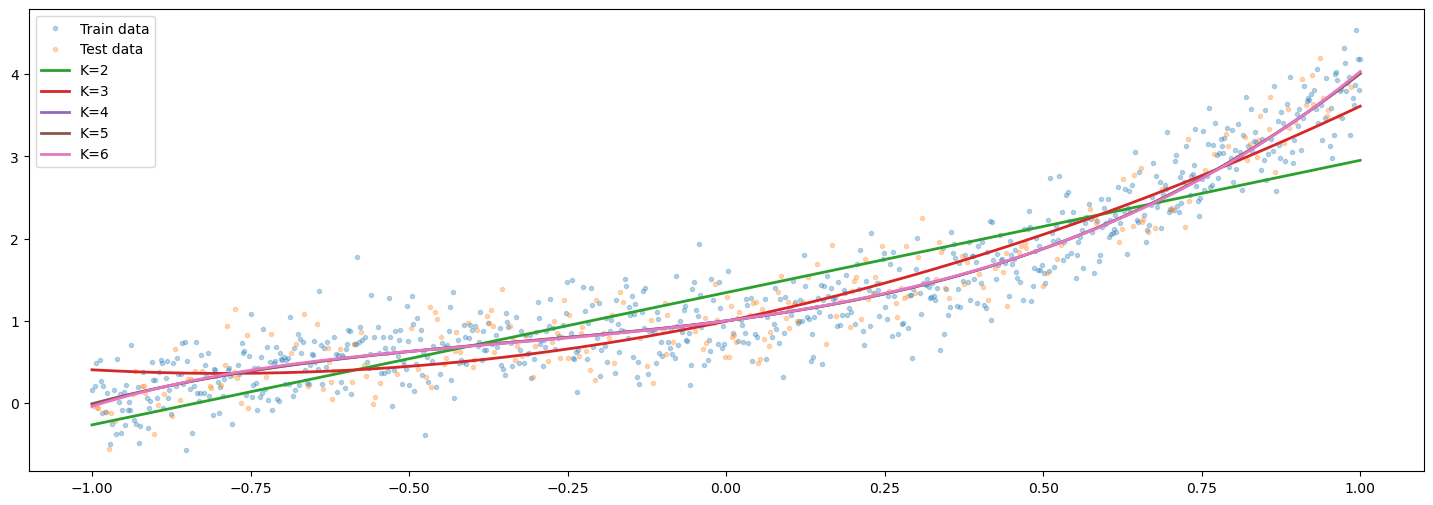

>>>>> lambda = 1.0 <<<<<
K=2 | Avg absolute error: [test] 0.19409219535462033  | [train] 0.21859444706184064 
K=3 | Avg absolute error: [test] 0.11083552295988862  | [train] 0.12491570005537947 
K=4 | Avg absolute error: [test] 0.0856803353136178   | [train] 0.09915948870634    
K=5 | Avg absolute error: [test] 0.08574633985021206  | [train] 0.09925462432686351 
K=6 | Avg absolute error: [test] 0.08541004403163     | [train] 0.09967981802546175 


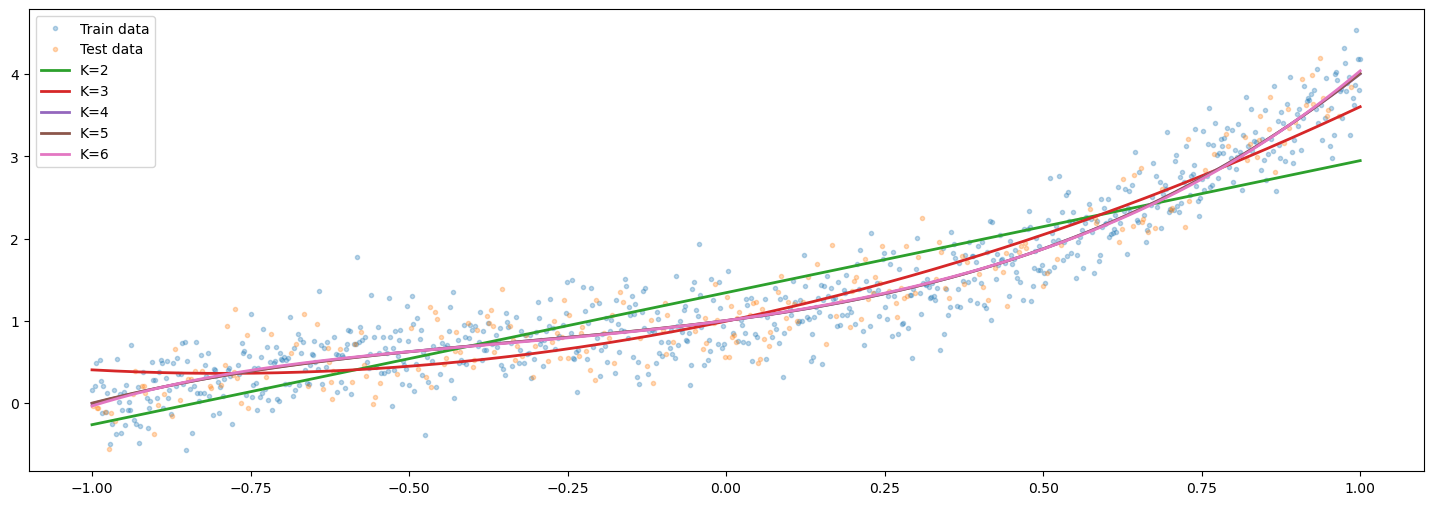

In [10]:
for to_try_lambda in np.linspace(0.1, 1, 5):
    print(f">>>>> lambda = {to_try_lambda} <<<<<")
    plotDataForVaryingK(MAPRegressor(K=None, lamb=to_try_lambda), X_train, Y_train, X_test, Y_test, real_K=K, K_variation=2, fig_size=(18,6), plot_error=False)

## MLE vs MAP

### Average absolute error for greater K

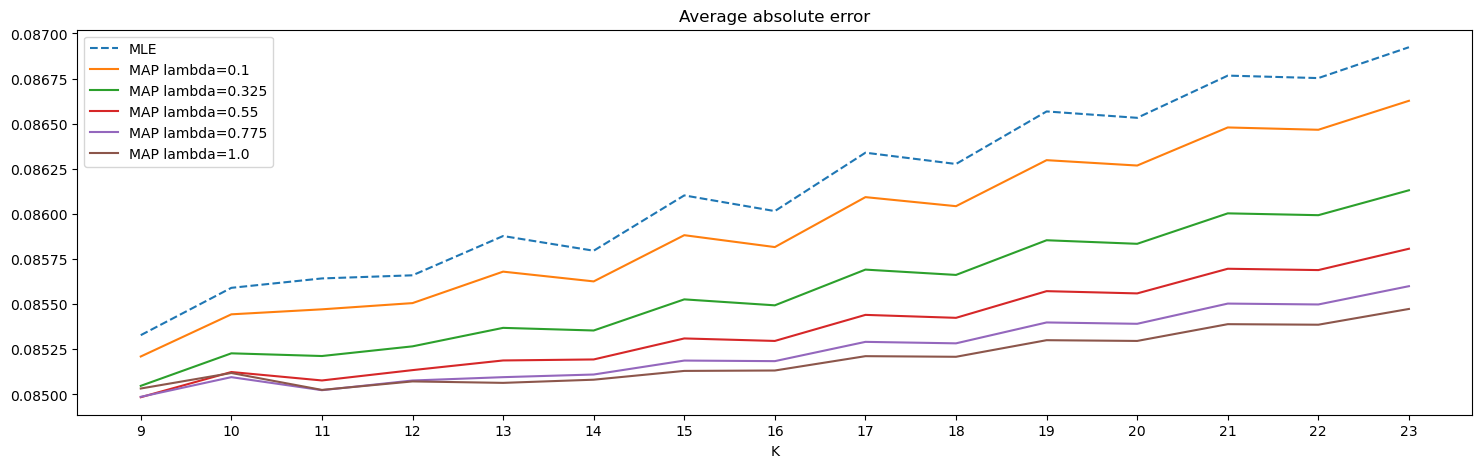

In [11]:
to_try_K = [K+i for i in range(5, 20)]
mle_abs_errors = []
to_try_lambda = np.linspace(0.1, 1, 5)
map_abs_errors = { l: [] for l in to_try_lambda }

for try_K in to_try_K:
    mle_model = MLERegressor(K=try_K)
    mle_model.fit(X_train, Y_train, epochs=1000)
    mle_abs_errors.append( avgAbsoluteError(mle_model, X_test, Y_test) )

    for i, lamb in enumerate(to_try_lambda):
        map_model = MAPRegressor(K=try_K, lamb=lamb)
        map_model.fit(X_train, Y_train, epochs=1000)
        map_abs_errors[lamb].append( avgAbsoluteError(map_model, X_test, Y_test) )

plt.figure(figsize=(18, 5))
plt.plot(to_try_K, mle_abs_errors, "--", label="MLE")
for lamb in to_try_lambda:
    plt.plot(to_try_K, map_abs_errors[lamb], label=f"MAP lambda={lamb}")
plt.title("Average absolute error")
plt.xlabel("K")
plt.xticks(to_try_K)
plt.legend()
plt.show()

### Theta error for greater K

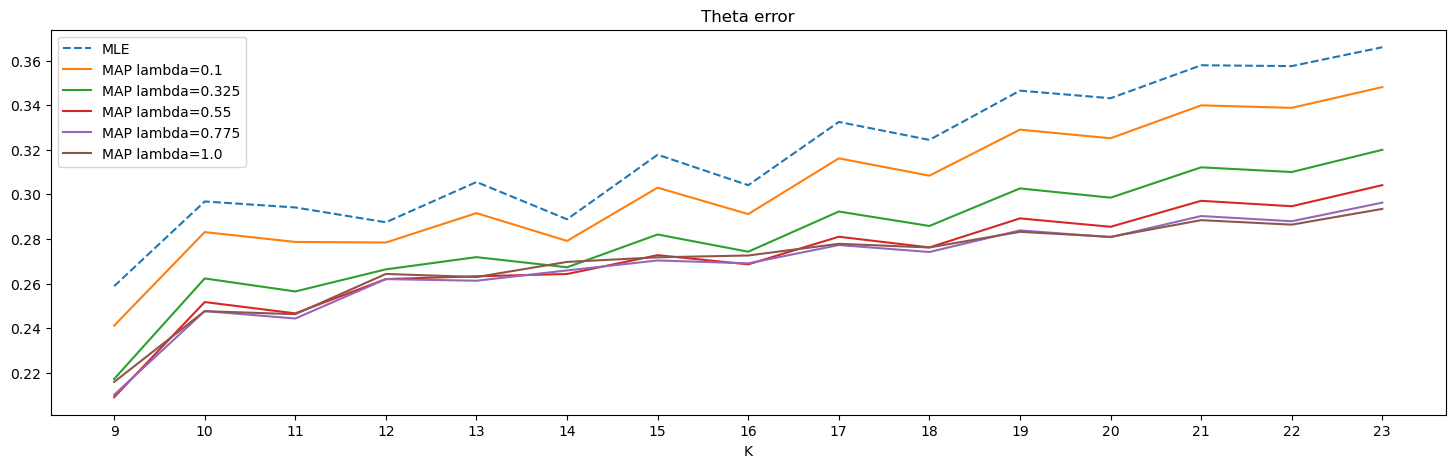

In [12]:
to_try_K = [K+i for i in range(5, 20)]
mle_theta_errors = []
to_try_lambda = np.linspace(0.1, 1, 5)
map_theta_errors = { l: [] for l in to_try_lambda }

for try_K in to_try_K:
    mle_model = MLERegressor(K=try_K)
    mle_model.fit(X_train, Y_train, epochs=1000)
    mle_theta_errors.append( thetaError(mle_model, theta_true) )

    for i, lamb in enumerate(to_try_lambda):
        map_model = MAPRegressor(K=try_K, lamb=lamb)
        map_model.fit(X_train, Y_train, epochs=1000)
        map_theta_errors[lamb].append( thetaError(map_model, theta_true) )

plt.figure(figsize=(18, 5))
plt.plot(to_try_K, mle_theta_errors, "--", label="MLE")
for lamb in to_try_lambda:
    plt.plot(to_try_K, map_theta_errors[lamb], label=f"MAP lambda={lamb}")
plt.title("Theta error")
plt.xlabel("K")
plt.xticks(to_try_K)
plt.legend()
plt.show()

### Different number of datapoints with correct K

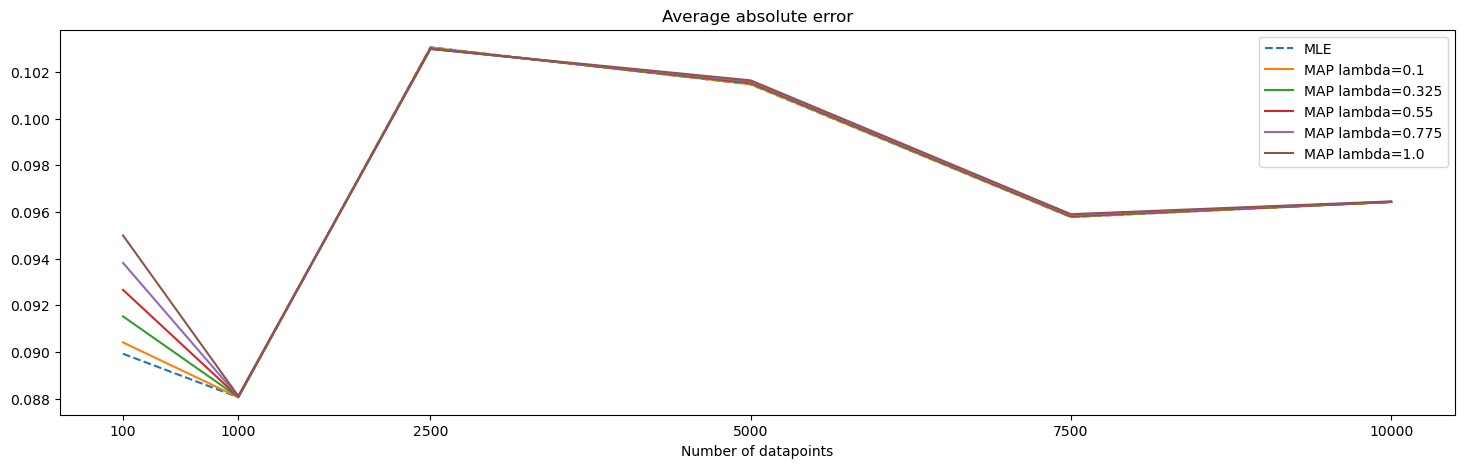

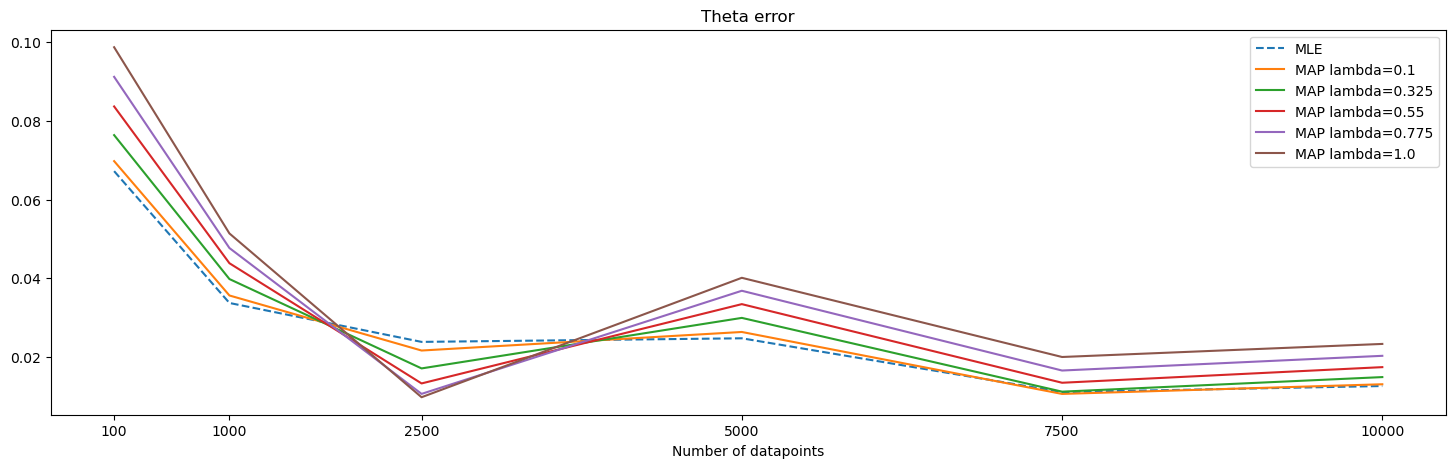

In [13]:
to_try_N = [100, 1000, 2500, 5000, 7500, 10000]
mle_abs_errors = []
mle_theta_errors = []
to_try_lambda = np.linspace(0.1, 1, 5)
map_abs_errors = { l: [] for l in to_try_lambda }
map_theta_errors = { l: [] for l in to_try_lambda }

for try_N in to_try_N:
    X_full, Y_full = createDataset(try_N, a, b, K, theta_true, variance)
    X_train, Y_train, X_test, Y_test = train_test_split(X_full, Y_full, int(0.75*X_full.shape[0]))

    mle_model = MLERegressor(K=K)
    mle_model.fit(X_train, Y_train, epochs=1000)
    mle_abs_errors.append( avgAbsoluteError(mle_model, X_test, Y_test) )
    mle_theta_errors.append( thetaError(mle_model, theta_true) )
    
    for lamb in to_try_lambda:
        map_model = MAPRegressor(K=K, lamb=lamb)
        map_model.fit(X_train, Y_train, epochs=1000)
        map_abs_errors[lamb].append( avgAbsoluteError(map_model, X_test, Y_test) )
        map_theta_errors[lamb].append( thetaError(map_model, theta_true) )


plt.figure(figsize=(18, 5))
plt.title("Average absolute error")
plt.plot(to_try_N, mle_abs_errors, "--", label="MLE")
for lamb in to_try_lambda:
    plt.plot(to_try_N, map_abs_errors[lamb], label=f"MAP lambda={lamb}")
plt.xlabel("Number of datapoints")
plt.xticks(to_try_N)
plt.legend()
plt.show()

plt.figure(figsize=(18, 5))
plt.title("Theta error")
plt.plot(to_try_N, mle_theta_errors, "--", label="MLE")
for lamb in to_try_lambda:
    plt.plot(to_try_N, map_theta_errors[lamb], label=f"MAP lambda={lamb}")
plt.xlabel("Number of datapoints")
plt.xticks(to_try_N)
plt.legend()
plt.show()

### Different optimizers

In [14]:
X_full, Y_full = createDataset(N, a, b, K, theta_true, variance)
X_train, Y_train, X_test, Y_test = train_test_split(X_full, Y_full, int(0.75*X_full.shape[0]))

          |        Theta error        |    Avg absolute error    
MLE (SGD) |       0.0215730900        |       0.0996949812       
MLE (GD)  |       0.0223507802        |       0.0997276443       
MLE (NEQ) |       0.0223900372        |       0.0997279998       
MAP (SGD) |       0.0196075046        |       0.0996397479       
MAP (GD)  |       0.0213193918        |       0.0997000097       
MAP (NEQ) |       0.0213572426        |       0.0997003545       


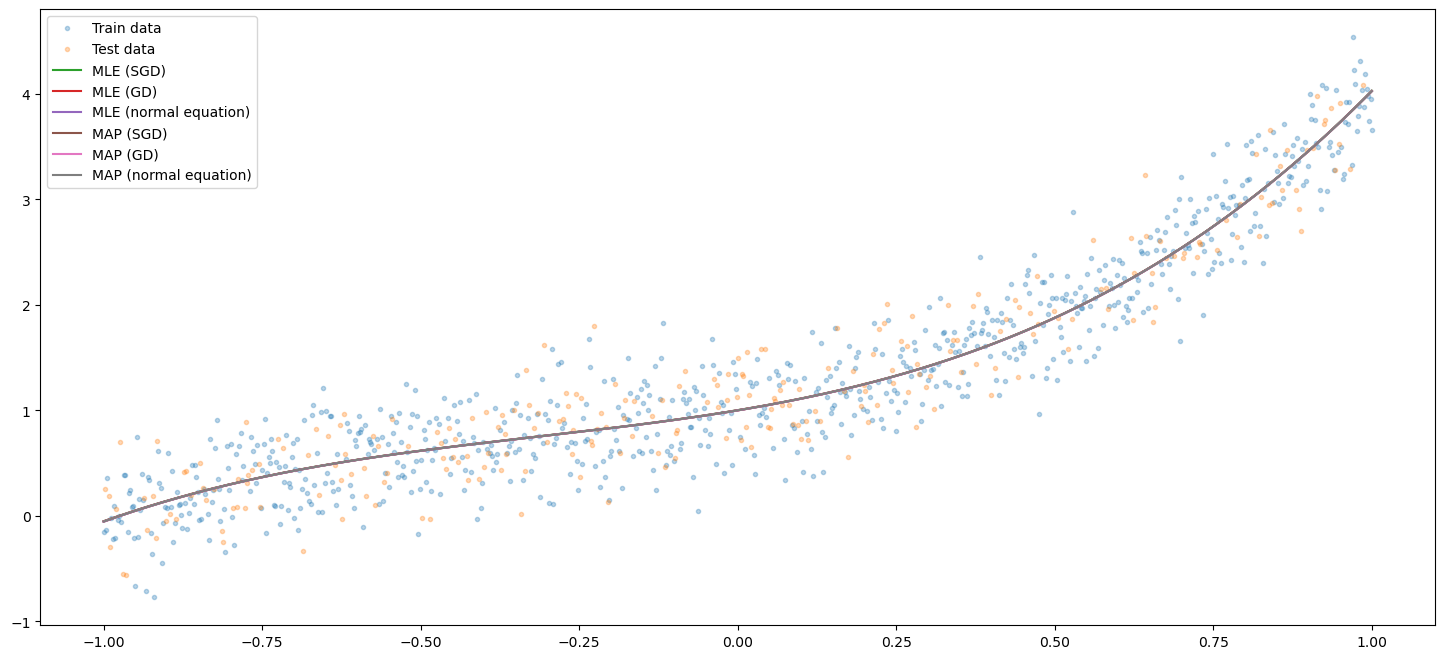

In [15]:
mle_model_sgd = MLERegressor(K=K).fit(X_train, Y_train, epochs=1000)
mle_model_gd = MLERegressor(K=K).fit_gd(X_train, Y_train, epochs=1000)
mle_model_neq = MLERegressor(K=K).fit_neq(X_train, Y_train)
map_model_sgd = MAPRegressor(K=K, lamb=0.1).fit(X_train, Y_train, epochs=1000)
map_model_gd = MAPRegressor(K=K, lamb=0.1).fit_gd(X_train, Y_train, epochs=1000)
map_model_neq = MAPRegressor(K=K, lamb=0.1).fit_neq(X_train, Y_train)


print(f"          | {'Theta error':^25} | {'Avg absolute error':^25}")

print(f"MLE (SGD) | {thetaError(mle_model_sgd, theta_true):^25.10f} | {avgAbsoluteError(mle_model_sgd, X_test, Y_test):^25.10f}")
print(f"MLE (GD)  | {thetaError(mle_model_gd, theta_true):^25.10f} | {avgAbsoluteError(mle_model_gd, X_test, Y_test):^25.10f}")
print(f"MLE (NEQ) | {thetaError(mle_model_neq, theta_true):^25.10f} | {avgAbsoluteError(mle_model_neq, X_test, Y_test):^25.10f}")

print(f"MAP (SGD) | {thetaError(map_model_sgd, theta_true):^25.10f} | {avgAbsoluteError(map_model_sgd, X_test, Y_test):^25.10f}")
print(f"MAP (GD)  | {thetaError(map_model_gd, theta_true):^25.10f} | {avgAbsoluteError(map_model_gd, X_test, Y_test):^25.10f}")
print(f"MAP (NEQ) | {thetaError(map_model_neq, theta_true):^25.10f} | {avgAbsoluteError(map_model_neq, X_test, Y_test):^25.10f}")


plt.figure(figsize=(18, 8))
plt.plot(X_train, Y_train, ".", alpha=0.3, label="Train data")
plt.plot(X_test, Y_test, ".", alpha=0.3, label="Test data")
plot_X = np.linspace(a, b, 10000)
plt.plot(plot_X, mle_model_sgd.predict(plot_X), label="MLE (SGD)")
plt.plot(plot_X, mle_model_gd.predict(plot_X), label="MLE (GD)")
plt.plot(plot_X, mle_model_neq.predict(plot_X), label="MLE (normal equation)")
plt.plot(plot_X, map_model_sgd.predict(plot_X), label="MAP (SGD)")
plt.plot(plot_X, map_model_gd.predict(plot_X), label="MAP (GD)")
plt.plot(plot_X, map_model_neq.predict(plot_X), label="MAP (normal equation)")
plt.legend()
plt.show()

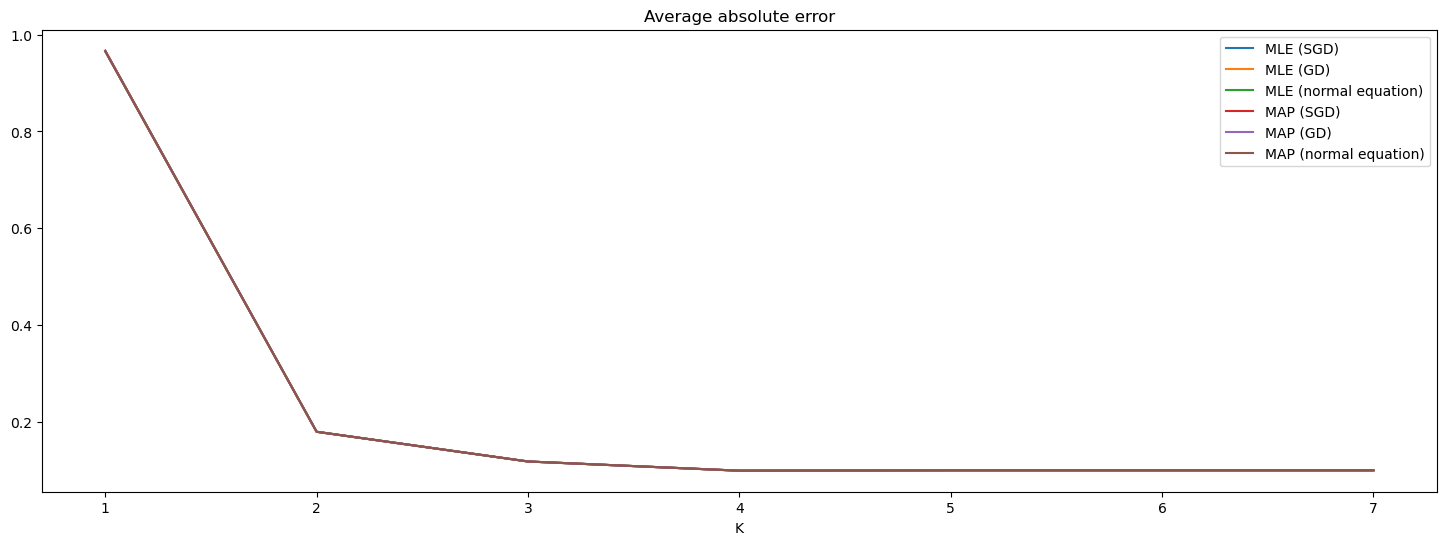

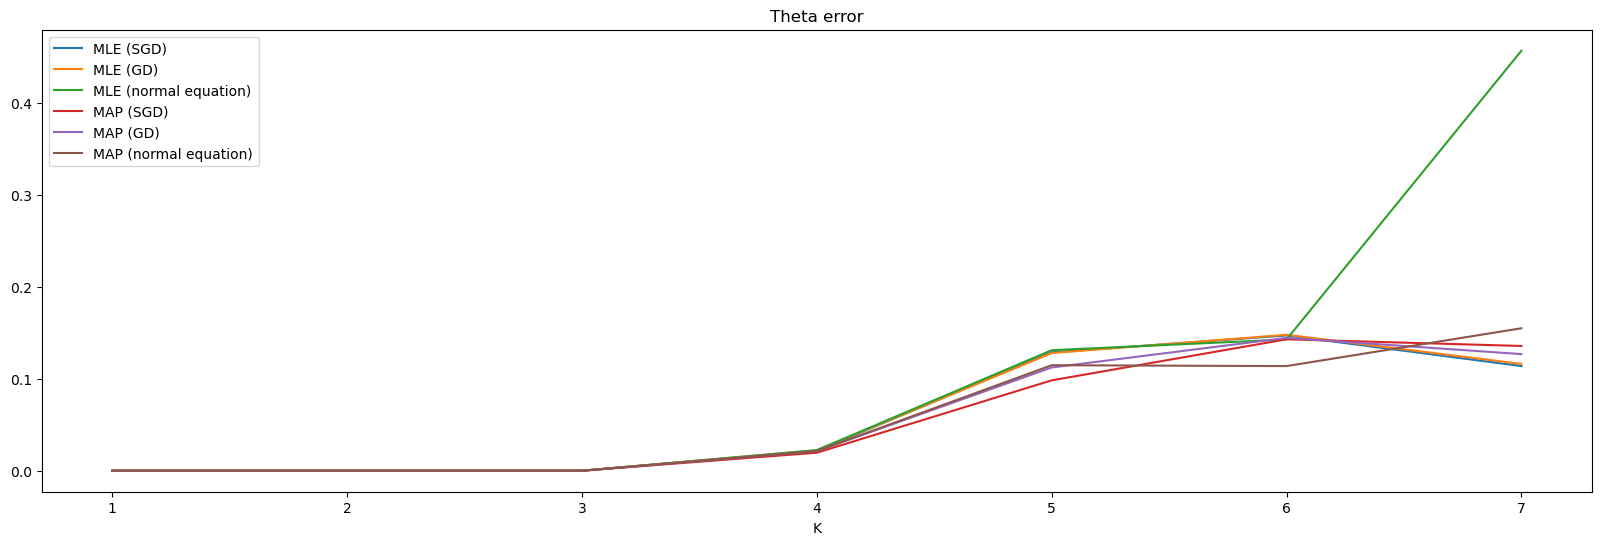

In [16]:
to_try_K = [*range(max(1, K-3), K)] + [K] + [*range(K+1, K+4)]
mle_sgd_abs_errors = []
mle_gd_abs_errors = []
mle_neq_abs_errors = []
map_sgd_abs_errors = []
map_gd_abs_errors = []
map_neq_abs_errors = []
mle_sgd_theta_errors = []
mle_gd_theta_errors = []
mle_neq_theta_errors = []
map_sgd_theta_errors = []
map_gd_theta_errors = []
map_neq_theta_errors = []

for try_K in to_try_K:
    mle_model_sgd = MLERegressor(K=try_K).fit(X_train, Y_train, epochs=2000)
    mle_model_gd = MLERegressor(K=try_K).fit_gd(X_train, Y_train, epochs=2000)
    mle_model_neq = MLERegressor(K=try_K).fit_neq(X_train, Y_train)
    map_model_sgd = MAPRegressor(K=try_K, lamb=0.1).fit(X_train, Y_train, epochs=2000)
    map_model_gd = MAPRegressor(K=try_K, lamb=0.1).fit_gd(X_train, Y_train, epochs=2000)
    map_model_neq = MAPRegressor(K=try_K, lamb=0.1).fit_neq(X_train, Y_train)

    mle_sgd_abs_errors.append( avgAbsoluteError(mle_model_sgd, X_test, Y_test) )
    mle_gd_abs_errors.append( avgAbsoluteError(mle_model_gd, X_test, Y_test) )
    mle_neq_abs_errors.append( avgAbsoluteError(mle_model_neq, X_test, Y_test) )
    map_sgd_abs_errors.append( avgAbsoluteError(map_model_sgd, X_test, Y_test) )
    map_gd_abs_errors.append( avgAbsoluteError(map_model_gd, X_test, Y_test) )
    map_neq_abs_errors.append( avgAbsoluteError(map_model_neq, X_test, Y_test) )
    if try_K >= K:
        mle_sgd_theta_errors.append( thetaError(mle_model_sgd, theta_true) )
        mle_gd_theta_errors.append( thetaError(mle_model_gd, theta_true) )
        mle_neq_theta_errors.append( thetaError(mle_model_neq, theta_true) )
        map_sgd_theta_errors.append( thetaError(map_model_sgd, theta_true) )
        map_gd_theta_errors.append( thetaError(map_model_gd, theta_true) )
        map_neq_theta_errors.append( thetaError(map_model_neq, theta_true) )
    else:
        mle_sgd_theta_errors.append(0)
        mle_gd_theta_errors.append(0)
        mle_neq_theta_errors.append(0)
        map_sgd_theta_errors.append(0)
        map_gd_theta_errors.append(0)
        map_neq_theta_errors.append(0)
    
plt.figure(figsize=(18, 6))
plt.plot(to_try_K, mle_sgd_abs_errors, label="MLE (SGD)")
plt.plot(to_try_K, mle_gd_abs_errors, label="MLE (GD)")
plt.plot(to_try_K, mle_neq_abs_errors, label="MLE (normal equation)")
plt.plot(to_try_K, map_sgd_abs_errors, label="MAP (SGD)")
plt.plot(to_try_K, map_gd_abs_errors, label="MAP (GD)")
plt.plot(to_try_K, map_neq_abs_errors, label="MAP (normal equation)")
plt.title("Average absolute error")
plt.xlabel("K")
plt.xticks(to_try_K)
plt.legend()
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(to_try_K, mle_sgd_theta_errors, label="MLE (SGD)")
plt.plot(to_try_K, mle_gd_theta_errors, label="MLE (GD)")
plt.plot(to_try_K, mle_neq_theta_errors, label="MLE (normal equation)")
plt.plot(to_try_K, map_sgd_theta_errors, label="MAP (SGD)")
plt.plot(to_try_K, map_gd_theta_errors, label="MAP (GD)")
plt.plot(to_try_K, map_neq_theta_errors, label="MAP (normal equation)")
plt.title("Theta error")
plt.xlabel("K")
plt.xticks(to_try_K)
plt.legend()
plt.show()